<a href="https://colab.research.google.com/github/Kynea0b/demo-nlp/blob/main/notebooks/8-emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 環境構築

In [2]:
# huggingface transformer のインストール
# - transformers : 主たるモジュール（モデルやトークナイザのダウンロード)
# - datasets : HuggingFaceで、データセットを扱うためのモジュール
# https://huggingface.co/docs/transformers/installation
! pip install transformers
! pip install datasets==v2.11.0

# 東北大学の日本語用BERT使用に必要なパッケージをインストール
! pip install fugashi ipadic

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 51.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.0/698.0 kB 33.8 MB/s eta 0:00:00
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=4fd58c82562a9836b5307121494b6865b037b21eb3f49787fa6ca40f4ae23a48
  Stored in directory: /root/.cache/pip/wheels/44/56/37/f543963822b85260c9f948df8fac8c20169c80dc71b24dc407
Successfully built ipadic


In [3]:
!ls /root/.cache/matplotlib

fontlist-v390.json


In [4]:
# [前準備] Matplotlib で日本語フォントを使用できるようにする
# cf. https://blog.3qe.us/entry/2018/08/16/121457
!apt-get -y install fonts-ipafont-gothic
#!rm /root/.cache/matplotlib/fontlist-v310.json
#!rm /root/.cache/matplotlib/fontlist-v300.json
!rm /root/.cache/matplotlib/fontlist-v390.json
!pip install japanize-matplotlib
!pip install unidic_lite
# NOTE ここで、ランタイムを再起動

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-ipafont-mincho
The following NEW packages will be installed:
  fonts-ipafont-gothic fonts-ipafont-mincho
0 upgraded, 2 newly installed, 0 to remove and 21 not upgraded.
Need to get 8,237 kB of archives.
After this operation, 28.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-gothic all 00303-21ubuntu1 [3,513 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-ipafont-mincho all 00303-21ubuntu1 [4,724 kB]
Fetched 8,237 kB in 1s (6,838 kB/s)
Selecting previously unselected package fonts-ipafont-gothic.
(Reading database ... 124926 files and directories currently installed.)
Preparing to unpack .../fonts-ipafont-gothic_00303-21ubuntu1_all.deb ...
Unpacking fonts-ipafont-gothic (00303-21ubuntu1) ...
Selecting previously unselected package fonts-ipa

### 日本語表示できるかテスト

Text(0.5, 1.0, '日本語を表示できるかテスト')

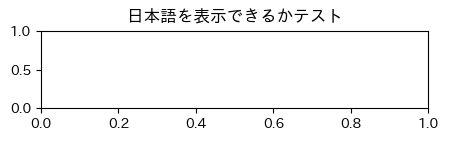

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

# sns.set_theme(font='IPAexGothic')
# 動作確認
plt.figure(figsize=(5,1))
plt.title('日本語を表示できるかテスト')

### Huggingface moduleのインストール

In [6]:
# huggingface transformer のインストール
# - transformers : 主たるモジュール（モデルやトークナイザのダウンロード)
# - datasets : HuggingFaceで、データセットを扱うためのモジュール
# https://huggingface.co/docs/transformers/installation
! pip install transformers
! pip install datasets==v2.11.0

## Huggingface ログイン

In [7]:
import os
HF_TOKEN = os.environ.get("HF_TOKEN")
from huggingface_hub import login

login(token=HF_TOKEN)

## モデルロード

In [8]:
# 一般的にpandasはpdと名前を付けてimportされる
import pandas as pd
import numpy as np

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer

In [9]:
model_name = "kynea0b/cl-tohoku-bert-base-japanese-v3-wrime-8-emotions"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/231k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

## 推論実行

#### ラベル作成

In [10]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']
emotion_names_jp = ['喜び', '悲しみ', '期待', '驚き', '怒り', '恐れ', '嫌悪', '信頼']  # 日本語版
num_labels = len(emotion_names)

#### 推論

In [11]:
# https://www.delftstack.com/ja/howto/numpy/numpy-softmax/
def np_softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

def analyze_emotion(text, show_fig=False, ret_prob=False):
    # 推論モードを有効か
    model.eval()

    # 入力データ変換 + 推論
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])
    out_dict = {n: p for n, p in zip(emotion_names_jp, prob)}

    # 棒グラフを描画
    if show_fig:
        plt.figure(figsize=(8, 3))
        df = pd.DataFrame(out_dict.items(), columns=['name', 'prob'])
        sns.barplot(x='name', y='prob', data=df)
        plt.title('入力文 : ' + text[:25], fontsize=15)

    if ret_prob:
        return out_dict

## rating 4以上

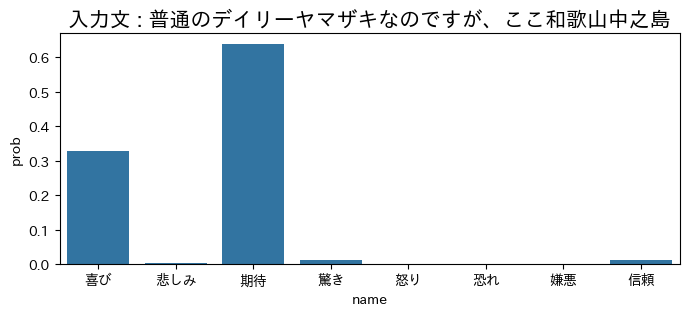

In [ ]:
analyze_emotion('普通のデイリーヤマザキなのですが、ここ和歌山中之島店は、程近くに地蔵の辻と言う場所があります。辻。。つまり交差点にお地蔵様が見守っておられます(現在は道路拡張工事の為にお地蔵様は少し移設)。その地蔵の辻にちなんだお地蔵様あんぱんがここ中之島店限定で販売されております。つぶあんと、そしてホイップクリームをサンドしたオリジナルあんぱんは美味しさ満点！お地蔵様と言う事で縁起物としてプレゼントされる方も多いそうですよ( ´▽｀)普通のコンビニとは少し違う、このオリジナルあんぱんを是非食べて下さいね♪', show_fig=True)


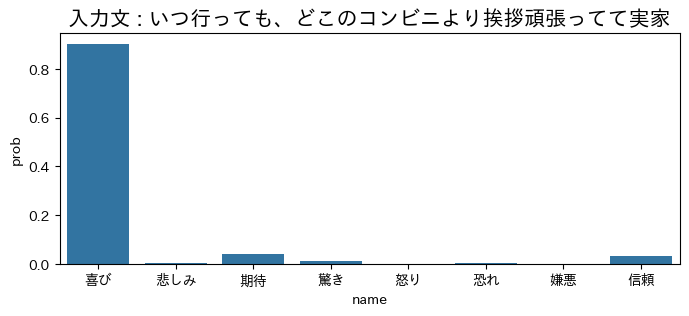

In [ ]:
analyze_emotion('いつ行っても、どこのコンビニより挨拶頑張ってて実家のような安心感がある。あんまり利用できなくて申し訳ないが良い店', show_fig=True)


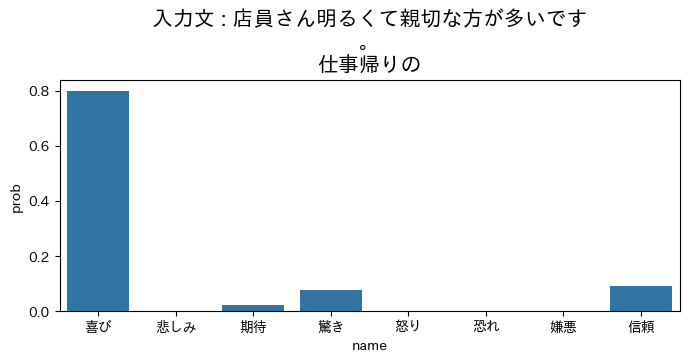

In [ ]:
analyze_emotion('店員さん明るくて親切な方が多いです\n。\n仕事帰りの時間帯に制服のまま寄るとお疲れ様でした！とか声かけてくれます。', show_fig=True)


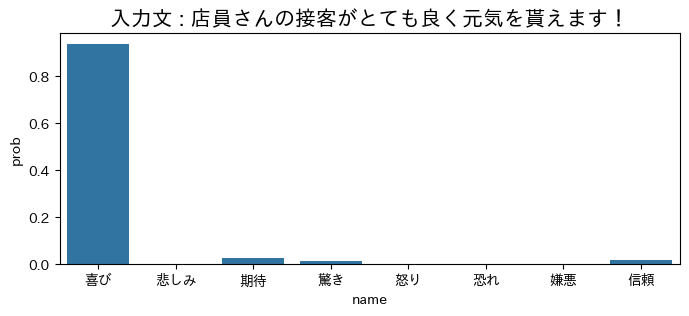

In [ ]:
analyze_emotion('店員さんの接客がとても良く元気を貰えます！', show_fig=True)


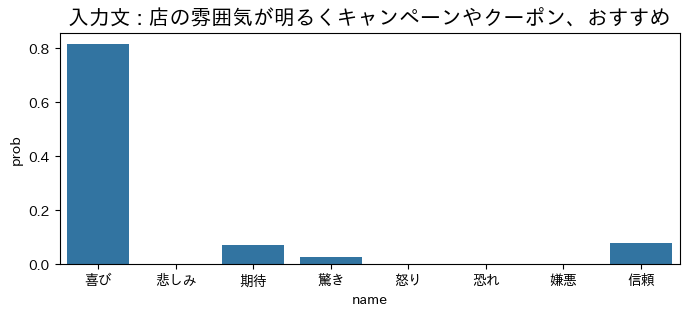

In [ ]:
analyze_emotion('店の雰囲気が明るくキャンペーンやクーポン、おすすめの物の声掛けをよくされてます。\nどの時間にも買い物に行きますが、皆さん愛想よく対応して下さるのと、他のお客様にも愛想よく対応されていていつも気分良く買い物させて頂いてます✨', show_fig=True)


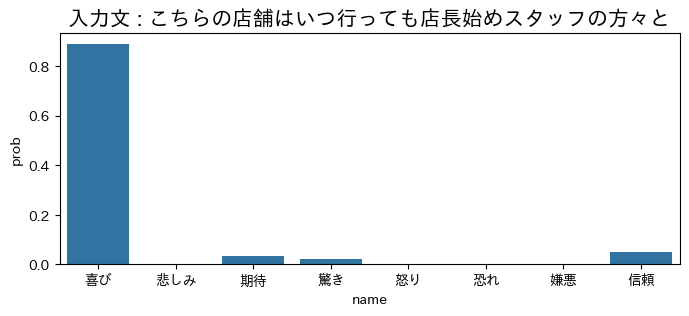

In [ ]:
analyze_emotion('こちらの店舗はいつ行っても店長始めスタッフの方々とても気分良くお買い物をさせてくれる雰囲気の良い明るいお店です。', show_fig=True)


## rating 1

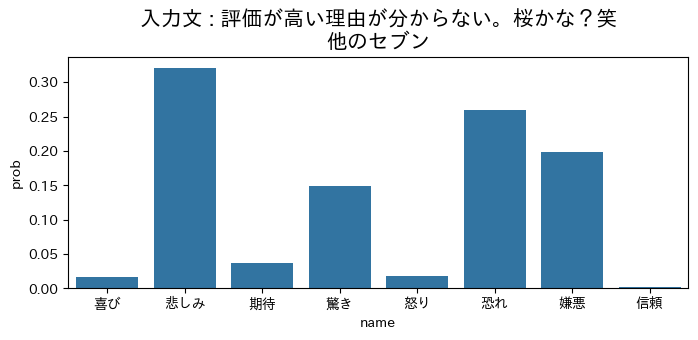

In [12]:
analyze_emotion('評価が高い理由が分からない。桜かな？笑\n他のセブン比べて外人クルー質が悪い。\nまず、弁当を立てて入れられそうになるし、8時から9時くらいに弁当を買ってもこちらから温めの指示しないと温めないしそういう教育してるかな？\n数人はいい接客する人がいるが、何年も働いている人だね。\n質が落ちたなと最近さらに感じる。', show_fig=True)


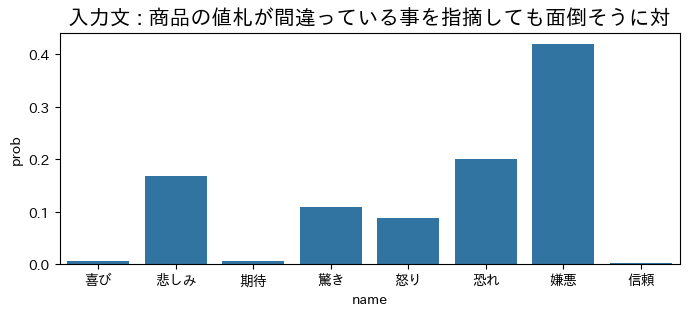

In [13]:
analyze_emotion('商品の値札が間違っている事を指摘しても面倒そうに対応され、更には結局間違ったまま。人としてどうなん？そしてお店としてもおかしい。', show_fig=True)


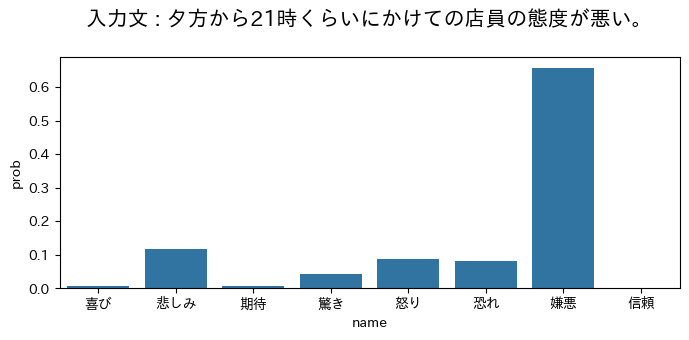

In [14]:
analyze_emotion('夕方から21時くらいにかけての店員の態度が悪い。\n・商品の前で雑談する\n・こちらが購入した商品を袋に投げ入れたり、台に投げたりする\n・すれ違う際に避けない\n・棚出し用のカゴを邪魔な位置に放置する\n・ホットスナックの調理が下手、美味しくない\n\n日本人労働者、外国人労働者どちらもレベルが低い。', show_fig=True)
